In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import ttest_1samp
from scipy.special import gammaln
from sklearn.metrics import mean_squared_error

# Obtain data

In [9]:
symbols = ['^GSPC', 'GOOG', 'MSFT']
symbols = ['^AEX', '^BFX', '^GDAXI']
start_date = '2010-01-01'
start_date = '2000-01-01'
end_date = '2022-04-08'
vPrices = yf.download(symbols, start=start_date, end=end_date)['Close']
vReturns = vPrices.pct_change().dropna() * 100
vNpReturns = np.array(vReturns.transpose())
vTrain = vNpReturns[:,:int(len(vNpReturns[0,:]) * 0.8)]
vTest = vNpReturns[:,int(len(vNpReturns[0,:]) * 0.8):]

[*********************100%***********************]  3 of 3 completed


In [10]:
np.corrcoef(vTrain)

array([[1.        , 0.8520774 , 0.8553289 ],
       [0.8520774 , 1.        , 0.77631372],
       [0.8553289 , 0.77631372, 1.        ]])

# CCC Model

### Here We will focuss on the CCC model and its loglikelihood 

In [4]:
def fnGARCH1Model(vPar, vData):
    iT = len(vData)
    dOmega = vPar[0]
    dAlpha = vPar[1]
    dBeta = vPar[2]

    vSig2 = np.zeros(iT)
    vSig2[0] = np.var(vData)

    for t in range(1,iT):
        vSig2[t] = dOmega + dAlpha * vData[t-1]**2 + dBeta * vSig2[t-1]
    return vSig2

def fnGJR_garch(vPar, vData):

    dOmega = vPar[0]
    dAlpha = vPar[1]
    dBeta = vPar[2]
    dGamma = vPar[3]
    T = len(vData)
    sigma2 = np.zeros(T)
    eps = vData 
    for t in range(0,T):
        if (t) == 0:
            sigma2[0] = np.var(vData)
        else:
            sigma2[t] = dOmega + dAlpha * eps[t-1]**2 + dGamma * eps[t-1]**2 * (eps[t-1]<0) + dBeta * sigma2[t-1]
    return sigma2


def fnThreeDimMulti(m1, m2):
    m3 = np.zeros(m1.shape)
    for t in range(m1.shape[2]):
        m3[:,:,t] = m1[:,:,t] @ m2[:,:,t]
    return m3

def fnMultiTimeDimVectorRightTranspose(v1, v2):
    v3 = np.zeros((v1.shape[0], v1.shape[0], v1.shape[1]))
    for t in range(v1.shape[1]):
        v3[:,:,t] = v1[:,t].reshape(3,1) @ v2[:,t].T.reshape(1,3)
    return v3

In [12]:
# One step code
def fnCCCOneStep(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    
    p = 0
    #print(vPar[0:3])
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGARCH1Model(vPar[i*3 : (i+1)*3], mData[i, :]))
        for j in range(iN):
            if i < mData.shape[0] & j > i:
                mR[i,j] = vPar[iN*3 + p]
                mR[j,i] = vPar[iN*3 + p]
                p += 1
    dLL = 0
    dNu = vPar[len(vPar)-1]
    k = iN
    for t in range(iT):
        mSigt[:,:,t] = mDt[:,:,t] @ mR @ mDt[:,:,t]
        dLL += gammaln((dNu+k)/2)-gammaln(dNu/2)-np.log(np.pi*(dNu-2))*(k/2)-0.5*np.log(np.linalg.det(mSigt[:,:,t]))-(dNu+k)/2*np.log(1+(mData[:,t].transpose()@np.linalg.inv(mSigt[:,:,t])@mData[:,t])/(dNu-2))
    #print(dLL)
    if vPar[1] + vPar[2] > 1:
        dLL = - np.inf
    elif vPar[4] + vPar[5] > 1:
        dLL = - np.inf
    elif vPar[7] + vPar[8] > 1:
        dLL = -np.inf
    print(dLL)
    return -dLL 

# One step code
def fnCCCPrediction(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    
    p = 0
    #print(vPar[0:3])
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGARCH1Model(vPar[i*3 : (i+1)*3], mData[i, :]))
        for j in range(iN):
            if i < mData.shape[0] & j > i:
                mR[i,j] = vPar[iN*3 + p]
                mR[j,i] = vPar[iN*3 + p]
                p += 1
    dLL = 0
    dNu = vPar[len(vPar)-1]
    k = iN
    for t in range(iT):
        mSigt[:,:,t] = mDt[:,:,t] @ mR @ mDt[:,:,t]
    return mSigt

In [17]:
bounds = [(0.00000001, 20), (0.00000001, 0.99999999), (0.00000001, 0.99999999)]*3 + [(-1, 1)]*3 + [(2.1, 100)]


options = {'maxiter': 5000, 'adaptive': True}
results = minimize(fnCCCOneStep, [0.25, 0.30, 0.30, 0.25, 0.30, 0.30, 0.25, 0.30, 0.30, 0.85, 0.85, 0.75, 3], bounds= bounds, options=options, args= vTrain, method= "Nelder-Mead")
results

-16849.773675690907
-16828.301831667344
-16840.267134763562
-16825.434808700982
-16837.846120159164
-16844.73049862686
-16837.747247066098
-16809.288108915585
-16827.845316611256
-16804.024507096452
-17382.080669265848
-17261.726814154634
-16843.896234117154
-16695.099149230387
-16629.938818255916
-16617.076235201668
-16652.775708508052
-16686.079820910945
-16672.407102841316
-16704.179050683462
-16631.985447450144
-16606.683972813353
-16592.13230843605
-16574.921599147343
-16558.78400557624
-16548.579555548793
-16531.95270631388
-16511.572060129267
-16493.218491828695
-16475.51731049099
-16456.29736178345
-16450.64362868142
-16432.429389029156
-16418.55001653868
-16400.751920101062
-16534.820829422795
-16487.77507596774
-16401.7323614726
-16378.628011351708
-16363.625498411635
-16429.48835454702
-16367.325580537785
-16371.047449578102
-16334.029098606303
-16324.232375007905
-16332.081317762677
-16308.269131383377
-16298.720730582858
-16291.82083455074
-16283.265530356779
-16287.749191

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 14560.06088945858
             x: [ 1.481e-02  5.453e-02 ...  8.066e-01  6.264e+00]
           nit: 2510
          nfev: 3544
 final_simplex: (array([[ 1.481e-02,  5.453e-02, ...,  8.066e-01,
                         6.264e+00],
                       [ 1.481e-02,  5.453e-02, ...,  8.066e-01,
                         6.264e+00],
                       ...,
                       [ 1.481e-02,  5.453e-02, ...,  8.066e-01,
                         6.264e+00],
                       [ 1.481e-02,  5.453e-02, ...,  8.066e-01,
                         6.264e+00]]), array([ 1.456e+04,  1.456e+04, ...,  1.456e+04,  1.456e+04]))

In [8]:
mSigma_t_CCC = fnCCCPrediction(results.x, vTest)

In [9]:
iN = np.shape(vTest)[0]
iT = np.shape(vTest)[1]

mDtElements = np.zeros((iN, iT))
mDtElements[:,0] = np.var(vTest, axis=1)
for d in range(iN):
    for t in range(1,iT):
        mDtElements[d,t] = results.x[d*3] + results.x[d*3 + 1] * np.array(vTest[d,t-1])**2 + results.x[d*3 +2] * mDtElements[d,t-1]
        
mDtElementsSqrt = np.sqrt(mDtElements)
mDt = np.zeros((iN,iN, iT))
for t in range(iT):
    mDt[:,:,t] = np.diag(mDtElementsSqrt[:,t])
#mDt = mDt.to(np.float64)

mE = vTest / np.sqrt(mDtElements)
mCor = np.corrcoef(mE)
mCorMultiDim = np.tile(mCor[:, :, np.newaxis], (1, 1, iT))

mPreSigmat = fnThreeDimMulti(mDt, mCorMultiDim)
mSigmat = fnThreeDimMulti(mPreSigmat, mDt)

In [51]:
results.x

array([ 4.02864645e-05,  2.66780810e-01,  7.33213053e-01,  1.12522751e-04,
        7.76641560e-01,  2.22014324e-01,  1.02188558e-04,  4.32753445e-01,
        4.35648821e-01,  5.88682471e-01, -7.38488637e-01, -5.96872146e-01,
        2.49757486e+00])

In [53]:
7.76641560e-01 +  2.22014324e-01

0.9986558839999999

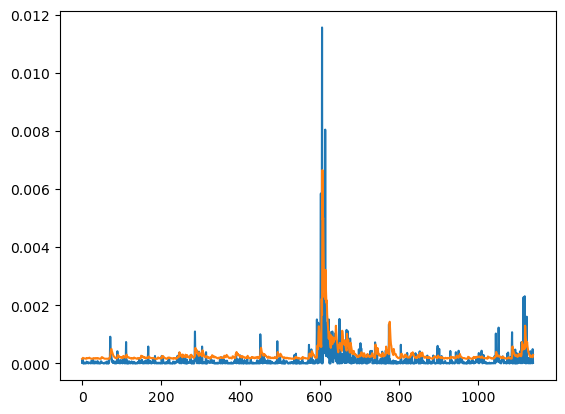

In [62]:
test = fnGARCH1Model([4.02864645e-05,  2.66780810e-01,  7.33213053e-01], vTest[1,:])

plt.plot(vTest[0,:]**2)
plt.plot(test)
plt.show()


In [ ]:
plt.plot(vTest[0,:]*vTest[1,:])
plt.plot(mSigma_t_CCC[i,i,:])
plt.show()

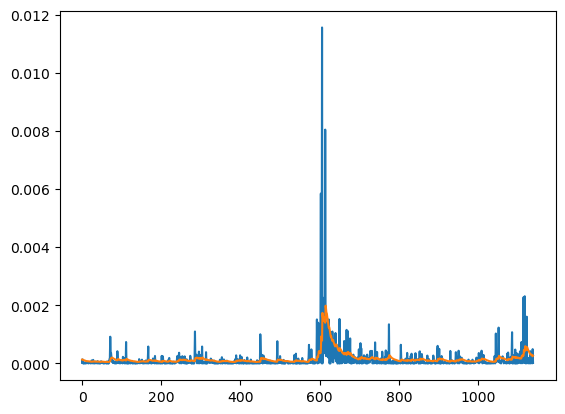

2.31151444351791e-07


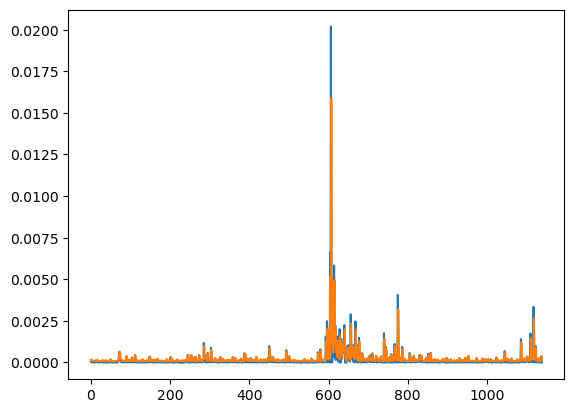

7.80638970374793e-07


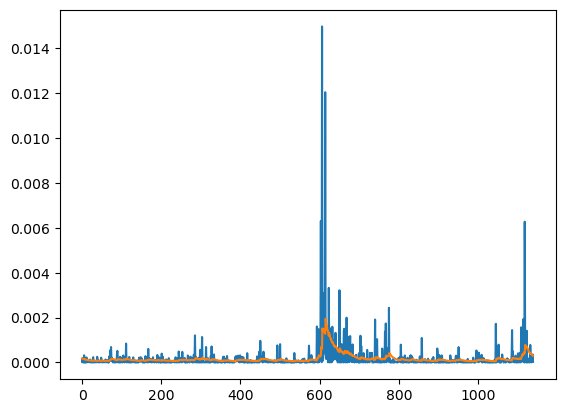

4.4389196015165453e-07


In [10]:
for i in range(3):
    plt.plot(vTest[i,:]**2)
    plt.plot(mSigma_t_CCC[i,i,:])
    plt.show()
    print(mean_squared_error(vTest[i,:]**2, mSigma_t_CCC[i,i,:]))
    


In [9]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(mSigmat[2,2,:], vNpReturns[2,:]**2))

1.5555653734912547e-07


##### Now we we calculate the diagonal matrix of the ccc model called the $D_t$ FOR THE NORMAL DISTRIBUTION

In [10]:
iN = np.shape(vNpReturns)[0]
iT = np.shape(vNpReturns)[1]

mDtElements = np.zeros((iN, iT))
mDtElements[:,0] = np.var(vNpReturns, axis=1)
for d in range(iN):
    for t in range(1,iT):
        mDtElements[d,t] = results.x[d*3] + results.x[d*3 + 1] * np.array(vNpReturns[d,t-1])**2 + results.x[d*3 +2] * mDtElements[d,t-1]
        
mDtElementsSqrt = np.sqrt(mDtElements)
mDt = np.zeros((iN,iN, iT))
for t in range(iT):
    mDt[:,:,t] = np.diag(mDtElementsSqrt[:,t])
#mDt = mDt.to(np.float64)

mE = vNpReturns / np.sqrt(mDtElements)
mCor = np.corrcoef(mE)
mCorMultiDim = np.tile(mCor[:, :, np.newaxis], (1, 1, iT))

mPreSigmat = fnThreeDimMulti(mDt, mCorMultiDim)
mSigmat = fnThreeDimMulti(mPreSigmat, mDt)

In [11]:
mEstimates[0,:]

NameError: name 'mEstimates' is not defined

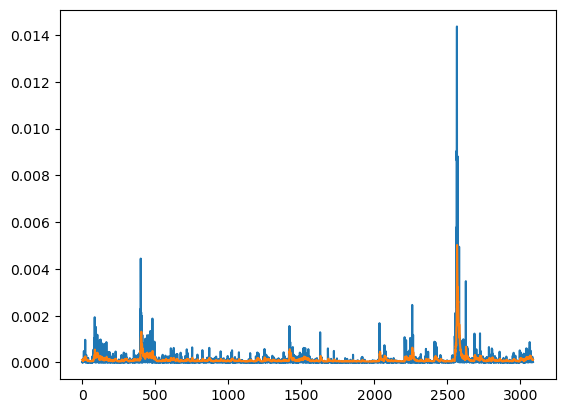

In [12]:
plt.plot(vNpReturns[2,:]**2)
# plt.plot(mSigmatStudentT[0,0,:])
plt.plot(mSigmat[2,2,:])
plt.show()

In [ ]:
plt.plot(vNpReturns[1,:]*vNpReturns[2,:])
# plt.plot(mSigmatStudentT[1,2,:])
plt.plot(mSigmat[1,2,:])
plt.show()

In [ ]:
plt.plot(vNpReturns[2,:]**2)
# plt.plot(mSigmatStudentT[2,2,:])
plt.plot(mSigmat[2,2,:])
plt.show()

# DCC Model

In [13]:
def fnDCCOneStep(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    
    p = 0
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGARCH1Model(vPar[i*3 : (i+1)*3], mData[i, :]))
    
    vEpsilon = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
    for t in range(iT):
        vEpsilon[:,:,t] = np.reshape(np.linalg.inv(mDt[:,:,t]) @ mData[:,t], (iN,1)) 
    
    mS = 0
    mEpsilon2 = np.zeros(mSigmat.shape)
    for t in range(iT):
        mS += vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
        mEpsilon2[:,:,t] = vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
    mS = mS / iT

    dA = vPar[iN*3]
    dB = vPar[iN*3 +1 ]
    dW = (1-dA-dB)

    mSig = np.zeros( (vEpsilon.shape[0], vEpsilon.shape[0], vEpsilon.shape[2]) )
    mSig[:,:,0] = np.cov(vEpsilon.reshape(iN,vEpsilon.shape[2]))
    for t in range(1, iT):
        mSig[:,:,t] = dW * mS + dA * (vEpsilon[:,:,t-1] @ vEpsilon[:,:,t-1].transpose()) + dB * mSig[:,:,t-1]
    k = iN
    dLL1 = 0 
    dLL2 = 0
    for t in range(iT):
        mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t])))) @ mSig[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t]))))
        dLL1 += k*np.log(2 * np.pi) + 2*np.log(np.linalg.det(mDt[:,:,t])) + (vEpsilon[:,:,t].transpose() @ vEpsilon[:,:,t])
        dLL2 += np.log(np.linalg.det(mRt)) + vEpsilon[:,:,t].transpose() @ np.linalg.inv(mRt) @ vEpsilon[:,:,t] - vEpsilon[:,:,t].transpose()@vEpsilon[:,:,t]
    dLL = -0.5*dLL1 -0.5*dLL2
    print(dLL)
    return -dLL[0][0]

In [13]:
def fnDCCOneStep(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    #mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    mS = 0
    # mEpsilon2 = np.zeros(mSigmat.shape)
    p = 0
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGARCH1Model(vPar[i*3 : (i+1)*3], mData[i, :]))
    
    vEpsilon = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
    for t in range(iT):
        vEpsilon[:,:,t] = np.reshape(np.linalg.inv(mDt[:,:,t]) @ mData[:,t], (iN,1)) 
        mS += vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
        # mEpsilon2[:,:,t] = vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()


    mS = mS / iT

    dA = vPar[iN*3]
    dB = vPar[iN*3 +1 ]
    dW = (1-dA-dB)

    mSig = np.zeros( (vEpsilon.shape[0], vEpsilon.shape[0], vEpsilon.shape[2]) )
    mSig[:,:,0] = np.cov(vEpsilon.reshape(iN,vEpsilon.shape[2]))
    k = iN
    dLL = 0 
    dNu = vPar[len(vPar) - 1]
    for t in range(iT):
        mSig[:,:,t] = dW * mS + dA * (vEpsilon[:,:,t-1] @ vEpsilon[:,:,t-1].transpose()) + dB * mSig[:,:,t-1]
        mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t])))) @ mSig[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t]))))
        mSigt = mDt[:,:,t] @ mRt @ mDt[:,:,t]
        #mSigt = np.sqrt(mSig[:,:,t]) @ mRt @ np.sqrt(mSig[:,:,t])
        dLL += gammaln((dNu+k)/2)-gammaln(dNu/2)-np.log(np.pi*(dNu-2))*(k/2)-0.5*np.log(np.linalg.det(mSigt))-(dNu+k)/2*np.log(1+(mData[:,t].transpose()@np.linalg.inv(mSigt)@mData[:,t])/(dNu-2))

    if vPar[1] + vPar[2] > 1:
        dLL = - np.inf
    elif vPar[4] + vPar[5] > 1:
        dLL = - np.inf
    elif vPar[7] + vPar[8] > 1:
        dLL = -np.inf    
    return -dLL

In [18]:
def fnDCCPrediction(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    mS = 0
    p = 0
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGARCH1Model(vPar[i*3 : (i+1)*3], mData[i, :]))
    
    vEpsilon = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
    for t in range(iT):
        vEpsilon[:,:,t] = np.reshape(np.linalg.inv(mDt[:,:,t]) @ mData[:,t], (iN,1)) 
        mS += vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()


    mS = mS / iT

    dA = vPar[iN*3]
    dB = vPar[iN*3 +1 ]
    dW = (1-dA-dB)

    mQ = np.zeros( (vEpsilon.shape[0], vEpsilon.shape[0], vEpsilon.shape[2]) )
    mQ[:,:,0] = np.cov(vEpsilon.reshape(iN,vEpsilon.shape[2]))
    mSigt = np.zeros( (vEpsilon.shape[0], vEpsilon.shape[0], vEpsilon.shape[2]) )
    k = iN
    dLL1 = 0 
    dLL2 = 0
    for t in range(iT):
        mQ[:,:,t] = dW * mS + dA * (vEpsilon[:,:,t-1] @ vEpsilon[:,:,t-1].transpose()) + dB * mQ[:,:,t-1]
        mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mQ[:,:,t])))) @ mQ[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mQ[:,:,t]))))
        mSigt[:,:,t] = mDt[:,:,t] @ mRt @ mDt[:,:,t]
    return mSigt

In [15]:
bounds = [(0.000001, 20), (0.00000001, 0.99999999), (0.00000001, 0.99999999)]*3 + [(0.000000001, 0.99999999)]*2 + [(2.1, 100)]
vIni = [np.var(vNpReturns[0,:])*(1-0.15-0.30), 0.15, 0.30, np.var(vNpReturns[1,:])*(1-0.15-0.25), 0.15, 0.25, np.var(vNpReturns[2,:])*(1-0.35-0.15), 0.35, 0.15, 0.3, 0.3, 2.5]
options = {'maxiter': 8000, 'xatol': 1e-3, 'adaptive': True}
results_DCC = minimize(fnDCCOneStep, vIni, args= vTrain, bounds = bounds, method= "Nelder-Mead", options=options)

C:\Users\onim-\AppData\Local\Temp\ipykernel_8408\2633731040.py:33: RuntimeWarning: invalid value encountered in sqrt
  mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t])))) @ mSig[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t]))))
c:\Users\onim-\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\onim-\AppData\Local\Temp\ipykernel_8408\2633731040.py:36: RuntimeWarning: invalid value encountered in log
  dLL += gammaln((dNu+k)/2)-gammaln(dNu/2)-np.log(np.pi*(dNu-2))*(k/2)-0.5*np.log(np.linalg.det(mSigt))-(dNu+k)/2*np.log(1+(mData[:,t].transpose()@np.linalg.inv(mSigt)@mData[:,t])/(dNu-2))


In [16]:
results_DCC

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -48804.7496624992
             x: [ 1.188e-06  5.923e-02  9.307e-01  1.460e-06  6.590e-02
                  9.198e-01  1.390e-06  5.743e-02  9.333e-01  2.573e-02
                  9.676e-01  8.444e+00]
           nit: 3416
          nfev: 4903
 final_simplex: (array([[ 1.188e-06,  5.923e-02, ...,  9.676e-01,
                         8.444e+00],
                       [ 1.188e-06,  5.922e-02, ...,  9.676e-01,
                         8.444e+00],
                       ...,
                       [ 1.189e-06,  5.922e-02, ...,  9.676e-01,
                         8.444e+00],
                       [ 1.188e-06,  5.923e-02, ...,  9.676e-01,
                         8.443e+00]]), array([-4.880e+04, -4.880e+04, ..., -4.880e+04, -4.880e+04]))

In [68]:
test =[ 1.188e-06,  5.922e-02,  9.307e-01,  1.460e-06,  6.590e-02,
                  9.198e-01,  1.390e-06,  5.743e-02,  9.333e-01,  2.573e-02,
                  9.676e-01,  8.444e+00]

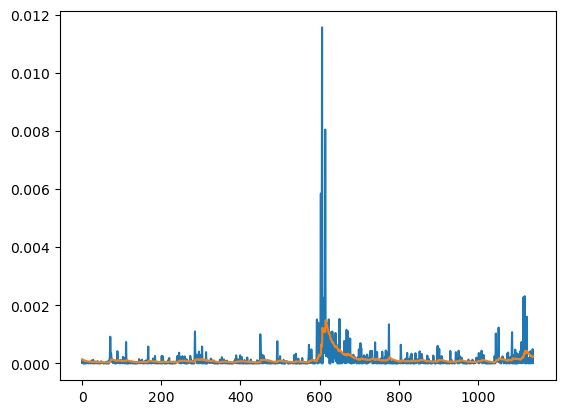

2.3011716402068087e-07


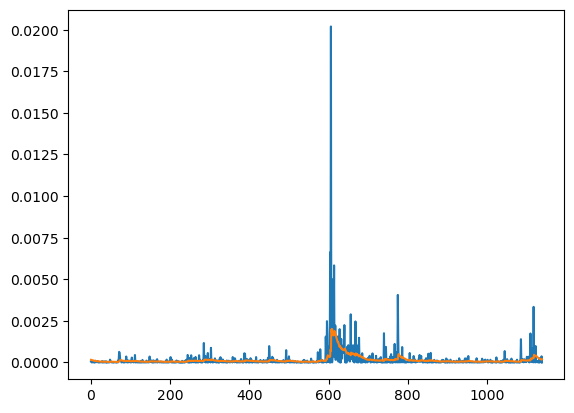

4.922060251562149e-07


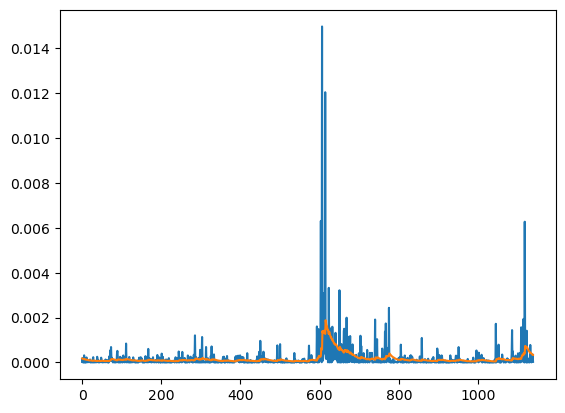

4.463514254660401e-07


In [19]:
mSigma_t_DCC = fnDCCPrediction(results_DCC.x, vTest)

#plt.plot(vNpReturns[0,:]*vNpReturns[2,:])
for i in range(3):
    plt.plot(vTest[i,:]**2)
    plt.plot(mSigma_t_DCC[i,i,:])
    plt.show()
    print(mean_squared_error(vTest[i,:]**2, mSigma_t_DCC[i,i,:]))

In [ ]:
#Calculate Epsilon vector
vEpsilon = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
for t in range(iT):
    vEpsilon[:,:,t] = np.reshape(np.linalg.inv(mDt[:,:,t]) @ vNpReturns[:,t], (iN,1)) 

#Calculate S matrix
mS = 0
mEpsilon2 = np.zeros(mSigmat.shape)
for t in range(iT):
    mS += vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
    mEpsilon2[:,:,t] = vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
mS = mS / iT

In [ ]:
def fnMinusLLGarchQMatrix(vPar, mData):
    iT = mData.shape[2]
    k = mData.shape[0]

    dA = vPar[0]
    dB = vPar[1]
    dW = (1-dA-dB)

    mSig = np.zeros( (mData.shape[0], mData.shape[0], mData.shape[2]) )
    mSig[:,:,0] = np.cov(mData.reshape(iN,mData.shape[2]))
    for t in range(1, iT):
        mSig[:,:,t] = dW * mS + dA * (mData[:,:,t-1] @ mData[:,:,t-1].transpose()) + dB * mSig[:,:,t-1]

    dLL1 = 0 
    dLL2 = 0
    for t in range(iT):
        mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t])))) @ mSig[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t]))))
        dLL1 += k*np.log(2 * np.pi) + 2*np.log(np.linalg.det(mDt[:,:,t])) + (mData[:,:,t].transpose() @ mData[:,:,t])
        dLL2 += np.log(np.linalg.det(mRt)) + mData[:,:,t].transpose() @ np.linalg.inv(mRt) @ mData[:,:,t] - mData[:,:,t].transpose()@mData[:,:,t]
    dLL = -0.5*dLL1 -0.5*dLL2
    return -dLL[0][0]


In [ ]:
def fnQmatrixDCC(vPar, mData):
    iT = mData.shape[2]
    k = mData.shape[0]

    dAlpha = vPar[0]
    dBeta = vPar[1]
    dOmega = (1-dAlpha-dBeta)

    mSig = np.zeros( (mData.shape[0], mData.shape[0], mData.shape[2]) )
    mSig[:,:,0] = np.cov(mData.reshape(iN,mData.shape[2]))
    
    for t in range(1, iT):
        mSig[:,:,t] = dOmega * mS + dAlpha * (mData[:,:,t-1] @ mData[:,:,t-1].transpose()) + dBeta * mSig[:,:,t-1]
    mRt = np.zeros( (mData.shape[0], mData.shape[0], mData.shape[2]) )
    for t in range(iT):
        mRt[:,:,t] = np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t])))) @ mSig[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mSig[:,:,t]))))
    return mRt

In [ ]:
results = minimize(fnMinusLLGarchQMatrix, [0.2,0.2], args= vEpsilon, method= "SLSQP")
mRt = fnQmatrixDCC(results.x, vEpsilon)
mPreSigmatDCC = fnThreeDimMulti(mDt, mRt)
mSigmatDCC = fnThreeDimMulti(mPreSigmatDCC, mDt)

In [ ]:
mDt[:,:,0]

In [ ]:
#plt.plot(vNpReturns[0,:]*vNpReturns[2,:])
for i in range(3):
    plt.plot(vNpReturns[i,:]**2)
    plt.plot(mSigmatDCC[i,i,:])
    #plt.plot(mSigmat[i,i, :])
    plt.show()

# BEKK Model  

In [35]:
def isnot_positive_definite(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    return np.all(eigenvalues <= 0)

In [38]:
def fnBEKKOneStep(vPar, mData):
    iN = mData.shape[0]
    k = iN
    iT = mData.shape[1]
    mOnes = np.ones((iN, iN))
    mA = np.diag(vPar[9:9+3])
    mB = np.diag(vPar[9+3:9+6])
    vA_diag = mA.diagonal()
    vB_diag = mB.diagonal()
    vSigma_bar = np.sum(fnMultiTimeDimVectorRightTranspose(mData, mData)) / iT
    mYY = fnMultiTimeDimVectorRightTranspose(mData, mData)
    mSigma_t = np.zeros((iN, iN, iT))
    mSigma_t[:,:,0] = vSigma_bar
    # mOmega = (mOnes @ mOnes.T - vA_diag @ vA_diag.T - vB_diag @ vB_diag.T) * vSigma_bar
    mOmega = np.array([[vPar[0], 0 , 0], [vPar[3], vPar[4], 0],  [vPar[6], vPar[7], vPar[8]]]) @ np.array([[vPar[0], vPar[1] , vPar[2]], [0, vPar[4], vPar[5]],  [0, 0, vPar[8]]])
    dLL = 0
    dNu = vPar[len(vPar) - 1]
    for t in range(1,iT):
        mSigma_t[:,:,t] = mOmega + mA @ mYY[:,:,t-1] @ mA + mB @ mSigma_t[:,:,t-1] @ mB
        dLL += gammaln((dNu+k)/2)-gammaln(dNu/2)-np.log(np.pi*(dNu-2))*(k/2)-0.5*np.log(np.linalg.det(mSigma_t[:,:,t]))-(dNu+k)/2*np.log(1+(mData[:,t].transpose()@np.linalg.inv(mSigma_t[:,:,t])@mData[:,t])/(dNu-2))
#     if isnot_positive_definite(mA):
#         dLL = -np.inf
#     elif vPar[9]**2 + vPar[12]**2 > 1:
#          dLL = -np.inf
#     elif vPar[10]**2 + vPar[13]**2 > 1:
#          dLL = -np.inf
#     elif vPar[11]**2 + vPar[14]**2 > 1:
#          dLL = -np.inf
    print(dLL)
    return -dLL

In [24]:
def fnBEKKPrediction(vPar, mData):
    iN = mData.shape[0]
    k = iN
    iT = mData.shape[1]
    mOnes = np.ones((iN, iN))
    mA = np.diag(vPar[9:9+3])
    mB = np.diag(vPar[9+3:9+6])
    vA_diag = mA.diagonal()
    vB_diag = mB.diagonal()
    vSigma_bar = np.sum(fnMultiTimeDimVectorRightTranspose(mData, mData)) / iT
    mYY = fnMultiTimeDimVectorRightTranspose(mData, mData)
    mSigma_t = np.zeros((iN, iN, iT))
    mSigma_t[:,:,0] = vSigma_bar
    mOmega = (mOnes @ mOnes.T - vA_diag @ vA_diag.T - vB_diag @ vB_diag.T) * vSigma_bar
    mOmega = np.array([[vPar[0], 0 , 0], [vPar[3], vPar[4], 0],  [vPar[6], vPar[7], vPar[8]]]) @ np.array([[vPar[0], vPar[1] , vPar[2]], [0, vPar[4], vPar[5]],  [0, 0, vPar[8]]])
    dLL = 0
    dNu = vPar[len(vPar) - 1]
    for t in range(1,iT):
        mSigma_t[:,:,t] = mOmega + mA.T @ mYY[:,:,t-1] @ mA + mB.T @ mSigma_t[:,:,t-1] @ mB
    return mSigma_t

In [39]:
vIni = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 4]
bounds = [(-20, 20)]*9 + [(0,1)]*6 + [(2.1, 100)]
vIni = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,4 ]
options = {'maxfev': 4000, 'disp': True, 'adaptive': True} 
vResults_BEKK = minimize(fnBEKKOneStep, vIni, args = vTrain, bounds = bounds, options=options, method = 'Nelder-Mead')

24061.42856027843
23855.803089848592
24058.472963011256
24062.579675276196
24058.472963011256
23845.641650981826
24059.90827389311
24062.57967527619
24059.90827389311
23845.112312268247
24061.379365004315
24061.423920879446
24061.411832989685
24059.200196616683
24058.913869946235
24059.01505995419
23729.01027779755
24362.091041782565
24409.095945687757
24272.21387563261
24324.56654340976
24370.44668198709
24199.336942523358
24216.93896624049
24235.87907691379
24258.347769133456
24283.50673215612
24311.49399201278
24343.48302474818
24377.864536051555
24418.271206029047
24441.104983711462
24466.85862596204
24492.885239602492
24522.263553128058
24551.95723802681
24584.33293951632
24618.118977676826
24656.2174863704
24694.84009634312
24574.36363763517
24601.13204284879
24627.7832103191
24651.83866580638
24701.43150598991
24730.942003671586
24732.11801092987
24761.102539285595
24760.26962634488
24823.540114777454
24858.551341691236
24850.010963210385
24911.079757785436
24950.054156596314
24

C:\Users\onim-\AppData\Local\Temp\ipykernel_8408\922493693.py:20: RuntimeWarning: invalid value encountered in log
  dLL += gammaln((dNu+k)/2)-gammaln(dNu/2)-np.log(np.pi*(dNu-2))*(k/2)-0.5*np.log(np.linalg.det(mSigma_t[:,:,t]))-(dNu+k)/2*np.log(1+(mData[:,t].transpose()@np.linalg.inv(mSigma_t[:,:,t])@mData[:,t])/(dNu-2))


41318.924017346915
41892.14107869523
41847.37071538677
42208.085941649624
42296.10121667878
nan
nan
41495.58832621408
nan
41535.03020179121
42269.317714437246
nan
41564.31836690022
nan
41582.296650852775
nan
41620.58493267994
42044.920289935566
nan
41638.09219549741
42215.85707583346
nan
41667.41693637898
42214.29217159258
nan
41709.60790023093
nan
41717.38495787738
42393.83541139597
nan
42179.04411699336
nan
41794.02851153192
42542.883513182576
nan
42469.52284637222
nan
41870.49182026234
42348.40915430435
nan
41890.79560136917
nan
41932.21845618637
42578.56694336506
nan
nan
41964.18727288549
nan
41978.23712745988
nan
41975.57872445659
nan
42010.84766884575
nan
42039.08371870569
nan
42044.72592270493
nan
42050.887338108136
nan
42075.07060438962
42542.22941339132
nan
42108.324966320215
42544.895057253816
nan
42123.2931225452
nan
42141.48735817294
nan
42167.13244843145
42621.93985646088
nan
nan
42200.603996350124
nan
42220.612678155034
nan
42235.740007164175
nan
42247.26505366451
42526.8

In [31]:
vResults_BEKK

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: nan
             x: [ 1.506e-02  1.471e-01 ...  1.057e-01  2.100e+00]
           nit: 1873
          nfev: 4000
 final_simplex: (array([[ 1.506e-02,  1.471e-01, ...,  1.057e-01,
                         2.100e+00],
                       [ 1.506e-02,  1.471e-01, ...,  1.057e-01,
                         2.100e+00],
                       ...,
                       [ 1.506e-02,  1.471e-01, ...,  1.057e-01,
                         2.100e+00],
                       [ 1.506e-02,  1.471e-01, ...,  1.057e-01,
                         2.100e+00]]), array([-4.740e+04,        nan, ...,        nan,        nan]))

In [148]:
vResults_BEKK.x

array([0.01273777, 0.17650484, 0.27783241, 0.12317617, 0.11368429,
       0.22955281, 0.28540053, 0.18337276, 0.04732829, 0.35215802,
       0.26842233, 0.40118326, 0.30765934, 0.26256472, 0.20992203,
       2.10140836])

In [150]:
0.26842233**2 +  0.26256472**2

0.14099077943130728

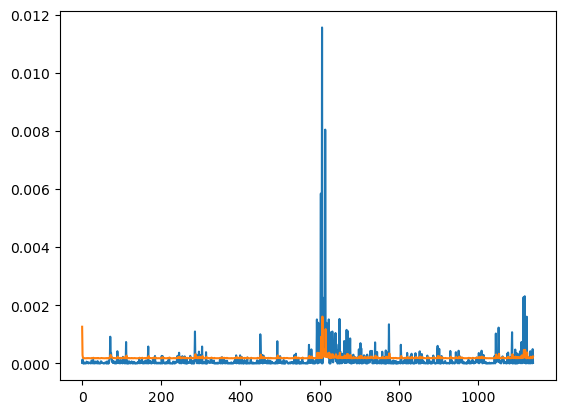

2.6061880957290104e-07


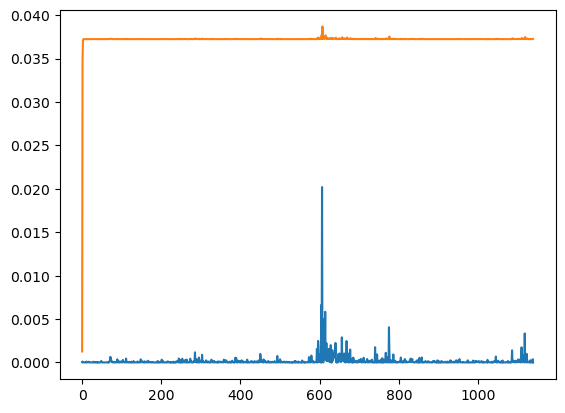

0.0013743956858740438


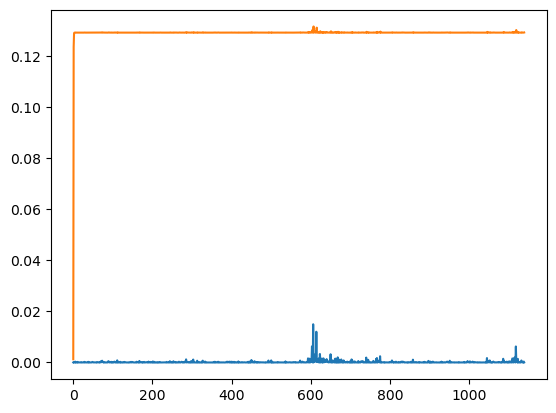

0.016671965830603385


In [147]:
mSigma_t_BEKK = fnBEKKPrediction(vResults_BEKK.x, vTest)

#plt.plot(vNpReturns[0,:]*vNpReturns[2,:])
for i in range(3):
    plt.plot(vTest[i,:]**2)
    plt.plot(mSigma_t_BEKK[i,i,:])
    plt.show()
    print(mean_squared_error(vTest[i,:]**2, mSigma_t_BEKK[i,i,:]))

# ADCC Model

In [118]:
def fnADCCOneStep(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    mS = 0
    mN = 0
    mEpsilon2 = np.zeros(mSigmat.shape)
    mN2 = np.zeros(mSigmat.shape)
    mSigma_t = np.zeros((iN, iN, iT))
    p = 0
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGJR_garch(vPar[i*4 : (i+1)*4], mData[i, :]))
    
    vEpsilon = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
    vN_t = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
    for t in range(iT):
        vEpsilon[:,:,t] = np.reshape(np.linalg.inv(mDt[:,:,t]) @ mData[:,t], (iN,1)) 
        bCondition = vEpsilon[:,:,t] < 0 
        vN = (bCondition + np.zeros((iN,1)) ) * vEpsilon[:,:,t]
        mN2[:,:,t] = vN @ vN.T
        mN += vN @ vN.T
        mS += vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
        mEpsilon2[:,:,t] = vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()

    mN_bar = mN / iT
    mS = mS / iT

    dA = vPar[iN*4]
    dB = vPar[iN*4 +1 ]
    dG = vPar[iN*4 +2 ]
    dW = (1-dA-dB)

    mQ = np.zeros( (vEpsilon.shape[0], vEpsilon.shape[0], vEpsilon.shape[2]) )
    mQ[:,:,0] = np.cov(vEpsilon.reshape(iN,vEpsilon.shape[2]))
    k = iN
    dLL = 0
    dNu = vPar[len(vPar) - 1]
    for t in range(iT):
        mQ[:,:,t] = dW * mS + dG * mN_bar +dA * (vEpsilon[:,:,t-1] @ vEpsilon[:,:,t-1].transpose()) + dB * mQ[:,:,t-1] + dG * mN2[:,:,t-1]
        mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mQ[:,:,t])))) @ mQ[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mQ[:,:,t]))))
        mSigma_t[:,:,t] = mDt[:,:,t] @ mRt @ mDt[:,:,t]
        dLL += gammaln((dNu+k)/2)-gammaln(dNu/2)-np.log(np.pi*(dNu-2))*(k/2)-0.5*np.log(np.linalg.det(mSigma_t[:,:,t]))-(dNu+k)/2*np.log(1+(mData[:,t].transpose()@np.linalg.inv(mSigma_t[:,:,t])@mData[:,t])/(dNu-2))

    if vPar[1] + vPar[2]/2 + vPar[3]> 1:
        dLL = - np.inf
    elif vPar[5] + vPar[6]/2 + vPar[7]> 1:
        dLL = - np.inf
    elif vPar[9] + vPar[10]/2 + vPar[11]> 1:
        dLL = -np.inf   
    elif dA + dB + dG > 1 or dA + dB + dG < 0:
        dLL = -np.inf   

    print(dLL)
    return -dLL

In [121]:
def fnADCCPrediction(vPar, mData):
    iN = mData.shape[0]
    iT = mData.shape[1]
    mDt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mSigt = np.zeros((mData.shape[0], mData.shape[0], mData.shape[1]))
    mR = np.identity(mData.shape[0])
    mS = 0
    mN = 0
    mEpsilon2 = np.zeros(mSigmat.shape)
    mN2 = np.zeros(mSigmat.shape)
    mSigma_t = np.zeros((iN, iN, iT))
    p = 0
    for i in range(iN):
        mDt[i, i, :] = np.sqrt(fnGJR_garch(vPar[i*4 : (i+1)*4], mData[i, :]))
    
    vEpsilon = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
    vN_t = np.zeros((mDt.shape[1], 1, mDt.shape[2]))
    for t in range(iT):
        vEpsilon[:,:,t] = np.reshape(np.linalg.inv(mDt[:,:,t]) @ mData[:,t], (iN,1)) 
        bCondition = vEpsilon[:,:,t] < 0 
        vN = (bCondition + np.zeros((iN,1)) ) * vEpsilon[:,:,t]
        mN2[:,:,t] = vN @ vN.T
        mN += vN @ vN.T
        mS += vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()
        mEpsilon2[:,:,t] = vEpsilon[:,:,t] @ vEpsilon[:,:,t].transpose()

    mN_bar = mN / iT
    mS = mS / iT

    dA = vPar[iN*4]
    dB = vPar[iN*4 +1 ]
    dG = vPar[iN*4 +2 ]
    dW = (1-dA-dB)

    mQ = np.zeros( (vEpsilon.shape[0], vEpsilon.shape[0], vEpsilon.shape[2]) )
    mQ[:,:,0] = np.cov(vEpsilon.reshape(iN,vEpsilon.shape[2]))
    k = iN
    for t in range(iT):
        mQ[:,:,t] = dW * mS + dG * mN_bar +dA * (vEpsilon[:,:,t-1] @ vEpsilon[:,:,t-1].transpose()) + dB * mQ[:,:,t-1] + dG * mN2[:,:,t-1]
        mRt = np.linalg.inv(np.sqrt(np.diag(np.diag(mQ[:,:,t])))) @ mQ[:,:,t] @ np.linalg.inv(np.sqrt(np.diag(np.diag(mQ[:,:,t]))))
        mSigma_t[:,:,t] = mDt[:,:,t] @ mRt @ mDt[:,:,t]
    return mSigma_t


In [119]:
bounds = [(0.000001, 20), (0.00000001, 0.99999999), (0.00000001, 0.99999999), (0,2)]*3 + [(0.000000001, 0.99999999)]*3 + [(2.1, 100)]
vIni = [np.var(vNpReturns[0,:])*(1-0.15-0.30), 0.15, 0.30, 0.2, np.var(vNpReturns[1,:])*(1-0.15-0.25), 0.15, 0.25, 0.2,  np.var(vNpReturns[2,:])*(1-0.35-0.15), 0.35, 0.15, 0.2, 0.3, 0.3, 0.3, 2.1]
options = {'maxiter': 10000, 'xatol': 1e-3}
vResults_ADCC = minimize(fnADCCOneStep, vIni, args = vTrain, bounds = bounds, options = options, method = 'Nelder-Mead')

43321.84966047482
43329.091467236576
43327.587782679984
43327.88343728023
43323.84861609915
43352.342103660936
43330.13925633073
43337.933271286325
43327.09629968724
43396.365366974234
43336.332791401386
43344.44700822177
43326.371670185945
43289.35440405405
43316.420092271495
43317.6209626473
45229.826221072544
43743.20094429557
43766.87070086721
43817.349921221445
43868.71867426937
43926.73909765395
43990.08031894813
44060.424472663806
44137.05134016986
44218.6785879047
44301.051284139445
44405.78481038341
44503.57996647244
44612.73408525826
44721.228604628464
44834.02600248543
44911.141459558625
44859.3579894658
44955.46759750348
45031.072840729066
45109.33357607614
45185.308818597245
45257.83502312856
45650.01545293233
45379.768652062434
45450.761785835944
45515.23519370875
45570.57129435463
45627.25683468606
45675.471183492606
46017.69168018667
45759.862313708065
45800.80365371926
45819.432169336695
45910.28130769883
45974.981828088465
46029.65883347474
46335.19568833969
46121.334

In [ ]:
vResults_ADCC

In [120]:
vResults_ADCC

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -48245.33736481218
             x: [ 1.551e-05  8.609e-02 ...  1.843e-01  5.599e+00]
           nit: 5627
          nfev: 7448
 final_simplex: (array([[ 1.551e-05,  8.609e-02, ...,  1.843e-01,
                         5.599e+00],
                       [ 1.551e-05,  8.611e-02, ...,  1.843e-01,
                         5.599e+00],
                       ...,
                       [ 1.551e-05,  8.607e-02, ...,  1.844e-01,
                         5.600e+00],
                       [ 1.551e-05,  8.610e-02, ...,  1.843e-01,
                         5.600e+00]]), array([-4.825e+04, -4.825e+04, ..., -4.825e+04, -4.825e+04]))

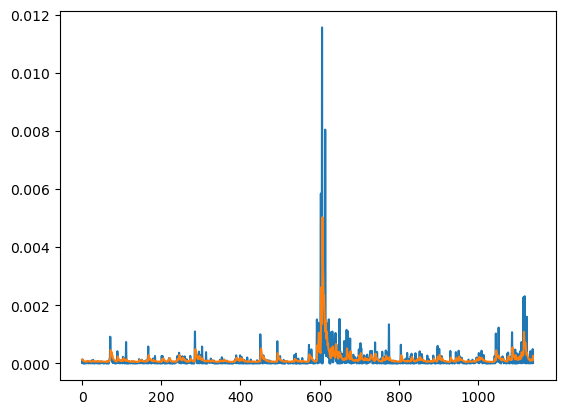

2.4585455109970953e-07


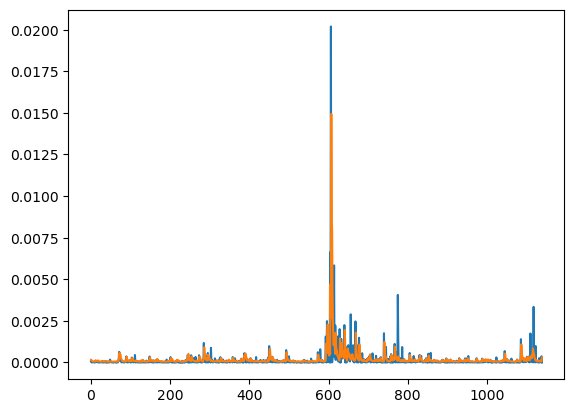

7.228728967319842e-07


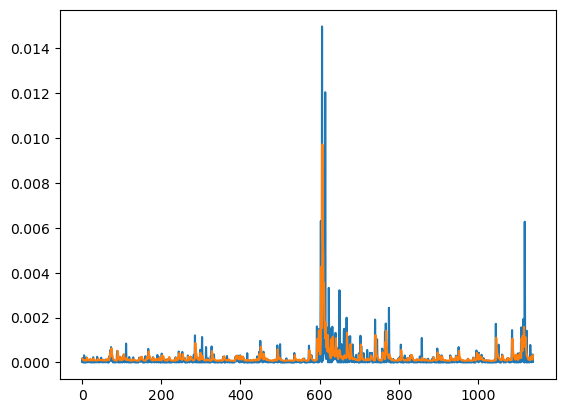

5.573169559084854e-07


In [123]:
mSigma_t_ADCC = fnADCCPrediction(vResults_ADCC.x, vTest)

#plt.plot(vNpReturns[0,:]*vNpReturns[2,:])
for i in range(3):
    plt.plot(vTest[i,:]**2)
    plt.plot(mSigma_t_ADCC[i,i,:])
    plt.show()
    print(mean_squared_error(vTest[i,:]**2, mSigma_t_ADCC[i,i,:]))